# Background Information Regarding our Project
The research into formatting bounding boxes and subsequently utilizing them

**We have taken the dataset provided by Sonic Automotive and performed some preprocessing and labeling to the images. We have manually extracted the values of the mileage/kilometers and units corresponding to each picture and stored these for use in accuracy checking later on. We have also created a program to put bounding boxes around areas of text that appear in the picture and plan on optimizing this in the future to only read the mileage/kilometers count in the images.** 

Our Project allows any user should be able to use our model to successfully be able to insert a photo of a vehicle's dashboard and be able to identify the odometer's value. This will be useful for automotive industries who may need to upload large amounts of odometer pictures accurately without the need for people.


The Beginning of our program consists of importing and shaping the data. We utilized detectron2 and many of its methods like RCNN which will allow us to perform bounding box methods in order to identify the digits located within the picture. Utilizing trainer models and with RCNN being the main object detection used, we then successfully display predictions with 80% accuracy to the users.At the end we use Pytesseract (a OCR tool python can use for images) to output the digits in the odometer readings..


In [ ]:
!pip install pytesseract

In [ ]:
!sudo apt install tesseract-ocr

Reading package lists... Done
Building dependency tree       
Reading state information... Done
tesseract-ocr is already the newest version (4.00~git2288-10f4998a-2).
0 upgraded, 0 newly installed, 0 to remove and 31 not upgraded.


In [ ]:
!pip install pickle5

In [ ]:
# install dependencies: 
!pip install pyyaml==5.1
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
# opencv is pre-installed on colab
# MIGHT HAVE TO RESTART RUNTIME AFTER THIS

1.8.1+cu101 True
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [ ]:
# install detectron2: (Colab has CUDA 10.1 + torch 1.8)
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
import torch
assert torch.__version__.startswith("1.8")   # need to manually install torch 1.8 if Colab changes its default version
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.8/index.html
# exit(0)  # After installation, you need to "restart runtime" in Colab. This line can also restart runtime

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.8/index.html


In [ ]:
%pylab inline
import os
import numpy as np
import matplotlib.pyplot as plt
import glob
import cv2 as cv
import pytesseract as tess
from google.colab import drive
from PIL import Image
from mpl_toolkits.axes_grid1 import ImageGrid
from pathlib import Path
import pandas as pd
import fastai.vision as fastv
import warnings
warnings.filterwarnings('ignore')

drive.mount("/content/drive")

working_dir = "/content/drive/My Drive/Group Ka-chow's Project/pngImages/"

Populating the interactive namespace from numpy and matplotlib
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
tess.pytesseract.tesseract_cmd = (
    r'/usr/bin/tesseract'
)

## **Loading in the pickle files**
We utilize the pickle5 module because "pickling" - the process of converting a python object hierarchy into a byte stream - is especially advantageous because it is in a python specific format. 

In [ ]:
import pickle
with open("/content/drive/My Drive/Group Ka-chow's Project/dataset/ed_finished_dataset.pickle", 'rb') as f:
    data = pickle.load(f)

In [ ]:
import pickle5 as pickle
with open("/content/drive/My Drive/Group Ka-chow's Project/dataset/newBoundingBoxes.pickle", 'rb') as f:
    boundingBoxesData = pickle.load(f)

# Bounding Box Creation
The bounding Box has been created above and the method below allows us to be able to visualize the image with the newly created box.

[712, 604]
[898, 650]


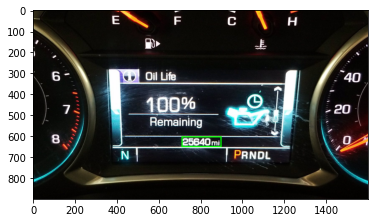

In [ ]:
# Function to help visualize bounding boxes in the images
def createBoundingBoxImage(index):
  copy = np.array(data[str(index)]['image'])
  try:
    for color in boundingBoxesData[index]:
      for xdelt in range(-3,3):
        for ydelt in range(-3,3):
          try:
            copy[color[1]+xdelt][color[0]+ydelt] = np.array([0,255,0])
          except:
            pass
  except:
    print(index)
  return copy

example = createBoundingBoxImage(90)
plt.imshow(example)
print(min(boundingBoxesData[90])) # smallest (x, y)
print(max(boundingBoxesData[90])) # largest (x, y)

In [ ]:
df = pd.DataFrame.from_dict(data).T
df['fileName'] = ['{}.png'.format(i) for i in range(len(data))]
df = df[['fileName', 'value']]
df

fileName     value
0      0.png     21868
1      1.png  014376.6
2      2.png     37120
3      3.png     31761
4      4.png     31706
..       ...       ...
108  108.png     35815
109  109.png     35712
110  110.png     34933
111  111.png     11778
112  112.png      6822

[113 rows x 2 columns]

## **Working with Detectron2**
The main piece of our program consists of utilizing detectron2. The purpose of this program is to go through all of our files and make a boundingbox based on the data and only searches for odometer. We also register odometer as the filters by storing it inside of the detectron2 catalog.


In [ ]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [ ]:
from google.colab.patches import cv2_imshow

In [ ]:
from detectron2.structures import BoxMode

# These two functions convert all of the data into COCO format for Detectron to be able to use

def get_odometer_dicts_for_training():
  datasetDicts = []

  # category = {'supercategory': 'object', 'id': 1, 'name': 'odometer'}
  # datasetDicts.append(category)

  for index, v in enumerate(df["fileName"][:90]):
    if index == 18:
      continue
    record = {}
    
    filename = os.path.join("/content/drive/My Drive/Group Ka-chow's Project/ed_filtered_train", v)

    record['file_name'] = filename
    record['height'] = 900
    record['width'] = 1600


    objs = []
    mins = min(boundingBoxesData[index])
    maxs = max(boundingBoxesData[index])
    obj = {
        "bbox": [mins[0], mins[1], maxs[0], maxs[1]],
        "bbox_mode": BoxMode.XYXY_ABS,
        "category_id": 0
    }
    objs.append(obj)
    record["annotations"] = objs
    datasetDicts.append(record)
  return datasetDicts

def get_odometer_dicts_for_testing():
  filteredDatasetDicts = []
  datasetDicts = []
  for index, v in enumerate(df["fileName"][90:]):
    record = {}
    record2 = {}
    
    filename = os.path.join("/content/drive/My Drive/Group Ka-chow's Project/ed_filtered_test", v)

    filename2 = os.path.join("/content/drive/My Drive/Group Ka-chow's Project/ed_test", v)

    record['file_name'] = filename
    record['height'] = 900
    record['width'] = 1600

    record2['file_name'] = filename2
    record2['height'] = 900
    record2['width'] = 1600

    objs = []
    mins = min(boundingBoxesData[index])
    maxs = max(boundingBoxesData[index])
    obj = {
        "bbox": [mins[0], mins[1], maxs[0], maxs[1]],
        "bbox_mode": BoxMode.XYXY_ABS,
        "category_id": 0
      }
    objs.append(obj)
    record["annotations"] = objs
    filteredDatasetDicts.append(record)

    objs2 = []
    mins = min(boundingBoxesData[index])
    maxs = max(boundingBoxesData[index])
    obj2 = {
        "bbox": [mins[0], mins[1], maxs[0], maxs[1]],
        "bbox_mode": BoxMode.XYXY_ABS,
        "category_id": 0
      }
    objs2.append(obj2)
    record2["annotations"] = objs2
    datasetDicts.append(record2)
  return filteredDatasetDicts, datasetDicts

# Adding the training and testing data to the datsetcatalog and metadatacatalog

from detectron2.data import DatasetCatalog, MetadataCatalog
DatasetCatalog.register("odometer/train", get_odometer_dicts_for_training)
DatasetCatalog.register("odometer/test", get_odometer_dicts_for_testing)
MetadataCatalog.get("odometer/train").set(thing_classes=["odometer"])
MetadataCatalog.get("odometer/test").set(thing_classes=["odometer"])
odometer_metadata = MetadataCatalog.get("odometer/train")

In [ ]:
temp = get_odometer_dicts_for_training() # See what the data looks like in COCO format
print(temp)

[{'file_name': "/content/drive/My Drive/Group Ka-chow's Project/ed_filtered_train/0.png", 'height': 900, 'width': 1600, 'annotations': [{'bbox': [441, 268, 955, 454], 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'category_id': 0}]}, {'file_name': "/content/drive/My Drive/Group Ka-chow's Project/ed_filtered_train/1.png", 'height': 900, 'width': 1600, 'annotations': [{'bbox': [933, 314, 1300, 385], 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'category_id': 0}]}, {'file_name': "/content/drive/My Drive/Group Ka-chow's Project/ed_filtered_train/2.png", 'height': 900, 'width': 1600, 'annotations': [{'bbox': [355, 459, 1421, 704], 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'category_id': 0}]}, {'file_name': "/content/drive/My Drive/Group Ka-chow's Project/ed_filtered_train/3.png", 'height': 900, 'width': 1600, 'annotations': [{'bbox': [301, 549, 1303, 754], 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'category_id': 0}]}, {'file_name': "/content/drive/My Drive/Group Ka-chow's Project/ed_filtered_train/4.png", 'height': 900, 

In [ ]:
# FOR UNREGISTERING THE DATASETS (RUN THIS IN CASE THE CELL BELOW FAILS AND THEN RUN THE CELL ABOVE AGAIN)
# DatasetCatalog.remove("odometer/train")
# DatasetCatalog.remove("odometer/test")
# MetadataCatalog.remove("odometer/train")
# MetadataCatalog.remove("odometer/test")

# **Visualize the training data**

Here we utilize the detectron2 visualize method to help display the bounding boxes

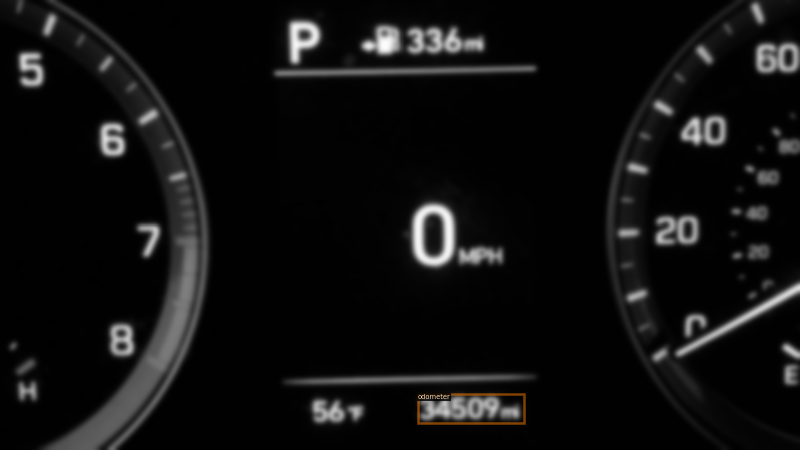

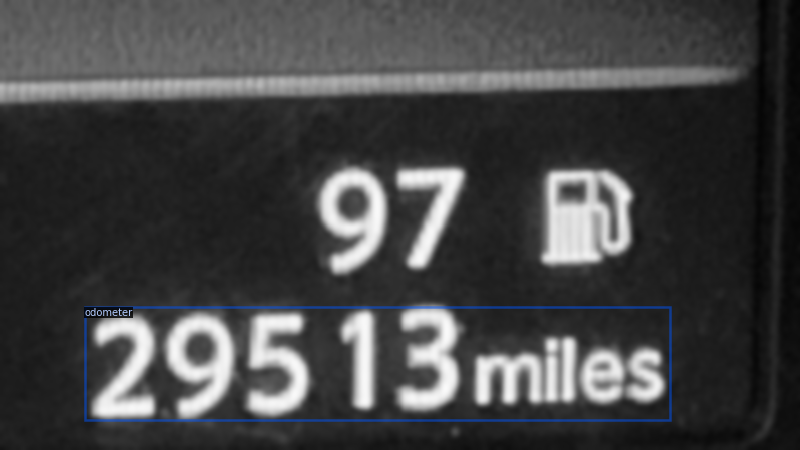

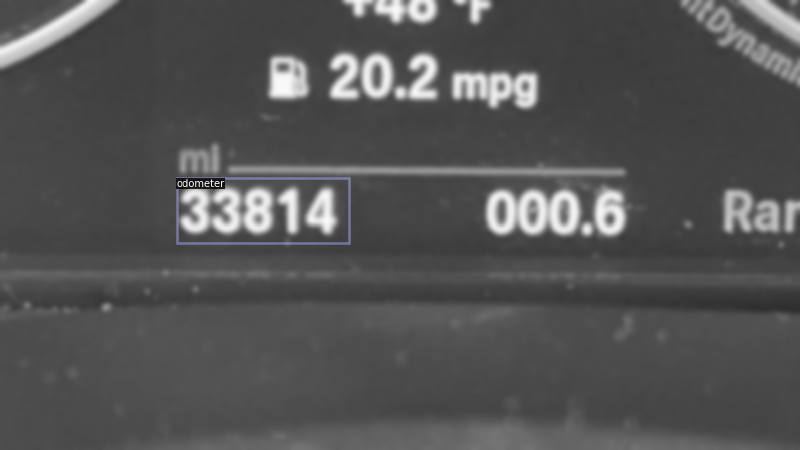

In [ ]:
import random
test = get_odometer_dicts_for_training()
for d in random.sample(test, 3):
    img = cv.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=odometer_metadata, scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    cv2_imshow(out.get_image()[:, :, ::-1])

# **Setting up the model and training**

The main process in our program is this step. We know that detectron2 already has a usable fasterrcnn model so we implement it. Using the pre-trained weights above we are able to apply them to the testing set by training them with a trainer object. This object will do all the training for us and is also included in detectron2.

For testing and debugging purposes we also setup an output directory which allows users to run the program and have the output sent to another file within the project.


In [ ]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_101_C4_3x.yaml")) # Use the faster_rcnn model
cfg.DATASETS.TRAIN = ("odometer/train") # Load in the training set
cfg.DATASETS.TEST = () # Dont need to testing set until after training
cfg.DATALOADER.NUM_WORKERS = 2 # Default
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_101_C4_3x.yaml")  # Let training weights initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2 # Default
cfg.SOLVER.BASE_LR = 0.0025  # Learning Rate
cfg.SOLVER.MAX_ITER = 500   # 500 iterations seems good enough
cfg.SOLVER.STEPS = []        # Do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # Faster, and good enough for this smaller dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # Only has one class (odometer). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)

cfg.OUTPUT_DIR = "/content/drive/My Drive/detectronOutput" # Redirected the output to your local drive (will override the previous model if you run twice)
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True) # The model will be outputed in the 'output' dir 
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[04/15 00:27:14 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): ResNet(
    (stem): BasicStem(
      (conv1): Conv2d(
        3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
        (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
      )
    )
    (res2): Sequential(
      (0): BottleneckBlock(
        (shortcut): Conv2d(
          64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=256, eps=1e-05)
        )
        (conv1): Conv2d(
          64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
        (conv2): Conv2d(
          64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
        (conv3): Conv2d(
          64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=256, eps=1e-05)
 

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 2048) in the checkpoint but (2, 2048) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (2,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 2048) in the checkpoint but (4, 2048) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.


[04/15 00:27:17 d2.engine.train_loop]: Starting training from iteration 0
[04/15 00:27:33 d2.utils.events]:  eta: 0:12:59  iter: 19  total_loss: 0.8835  loss_cls: 0.5459  loss_box_reg: 0.1263  loss_rpn_cls: 0.2045  loss_rpn_loc: 0.02619  time: 0.7882  data_time: 0.0174  lr: 4.9952e-05  max_mem: 3073M
[04/15 00:27:49 d2.utils.events]:  eta: 0:12:51  iter: 39  total_loss: 0.5868  loss_cls: 0.2422  loss_box_reg: 0.1987  loss_rpn_cls: 0.1263  loss_rpn_loc: 0.04515  time: 0.7971  data_time: 0.0007  lr: 9.9902e-05  max_mem: 3073M
[04/15 00:28:05 d2.utils.events]:  eta: 0:12:36  iter: 59  total_loss: 0.6316  loss_cls: 0.2278  loss_box_reg: 0.2655  loss_rpn_cls: 0.07122  loss_rpn_loc: 0.01856  time: 0.7956  data_time: 0.0010  lr: 0.00014985  max_mem: 3073M
[04/15 00:28:21 d2.utils.events]:  eta: 0:12:23  iter: 79  total_loss: 0.5949  loss_cls: 0.1781  loss_box_reg: 0.3351  loss_rpn_cls: 0.04964  loss_rpn_loc: 0.03733  time: 0.8010  data_time: 0.0007  lr: 0.0001998  max_mem: 3073M
[04/15 00:28:

In [ ]:
# Load tensorboard to see loss
%reload_ext tensorboard
%tensorboard --logdir "/content/drive/My Drive/detectronOutput"

Reusing TensorBoard on port 6006 (pid 2395), started 1:58:35 ago. (Use '!kill 2395' to kill it.)

<IPython.core.display.Javascript object>

# **Setting up a predictor**

The new weights we just generated will be retrieved and we will then utilize the detectron2 default predictor and pass in our configuration. We return testing data and pass that image into the predictor and have a visualize method to display the data. Afterwards we draw our predicted bounding boxes. We then visualize our newly predicted data. For the final piece we utilize pytesseract which is an OCR that is very useful for pictures and display the readings from the odometers.

In [ ]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained (If the model is good I would export / download it)
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.8   # set a custom testing threshold (80% is good in my opinion)
predictor = DefaultPredictor(cfg)

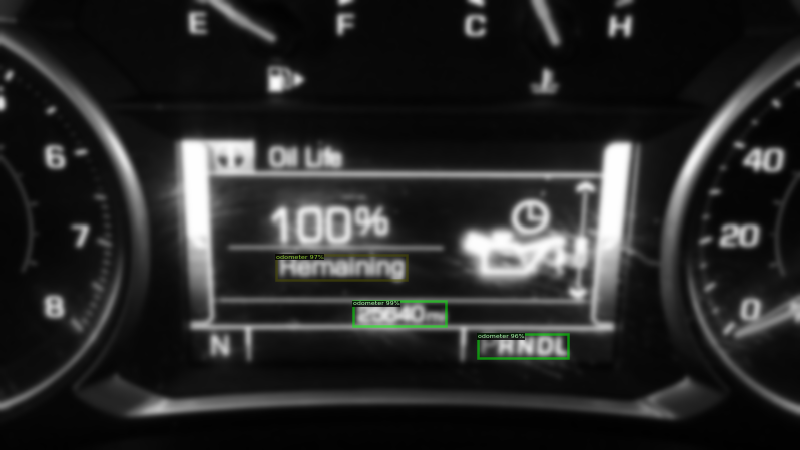

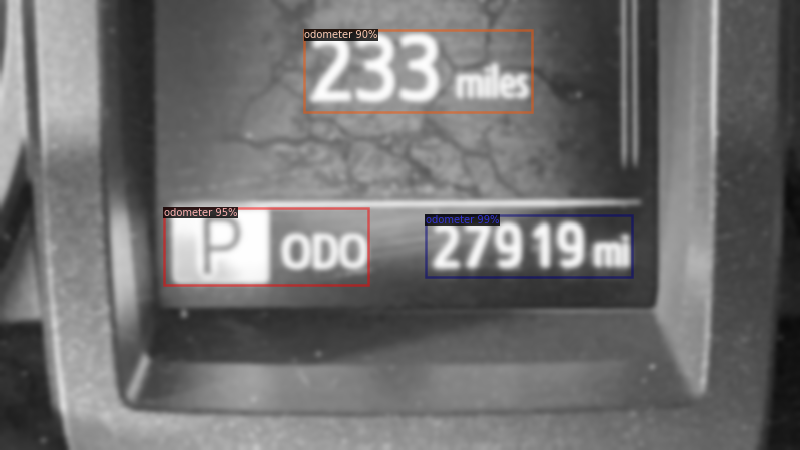

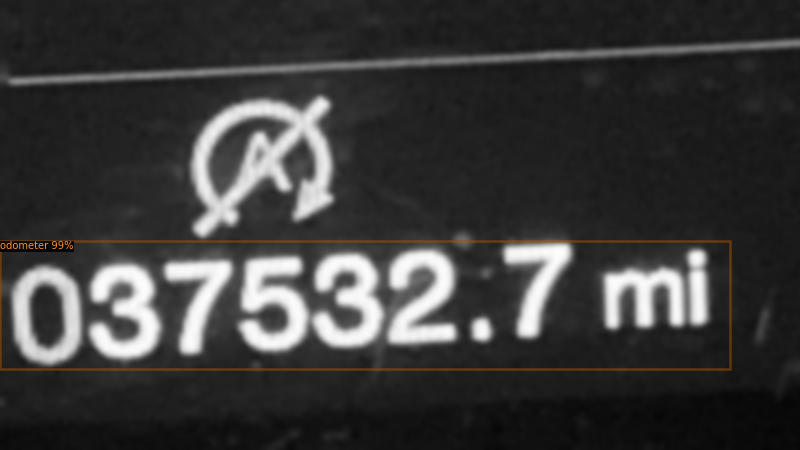

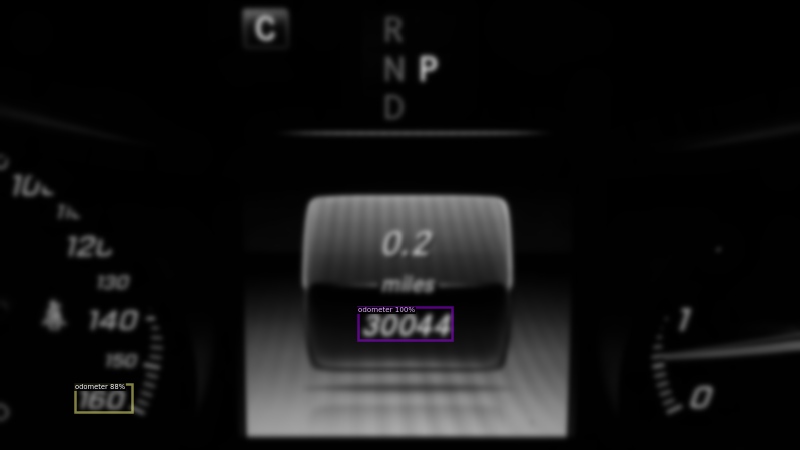

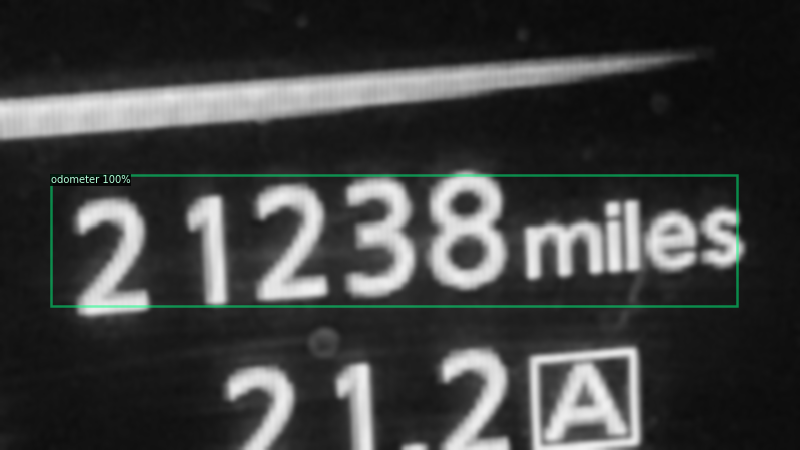

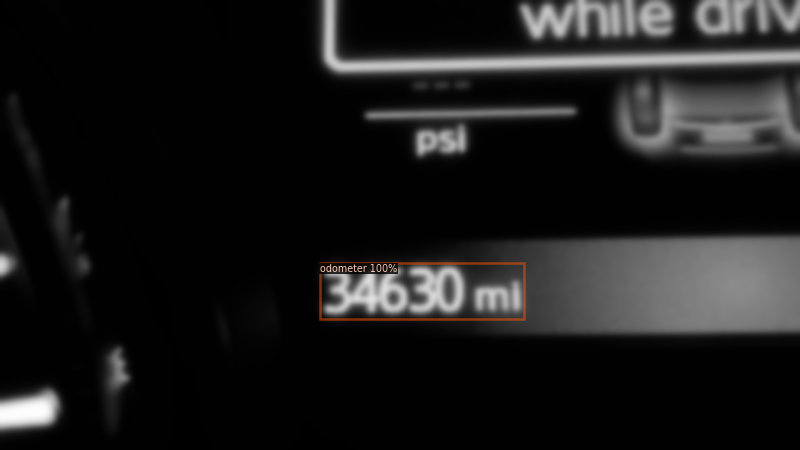

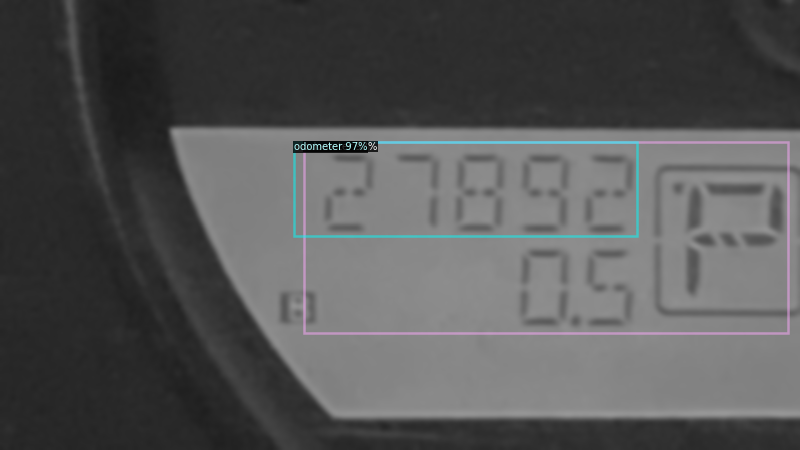

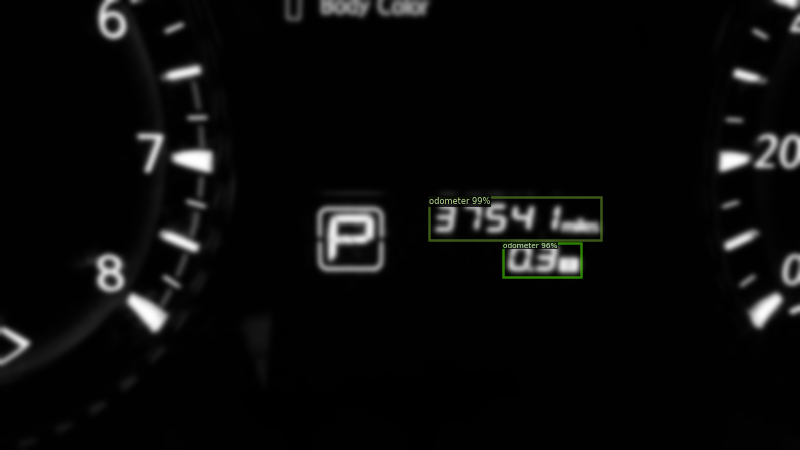

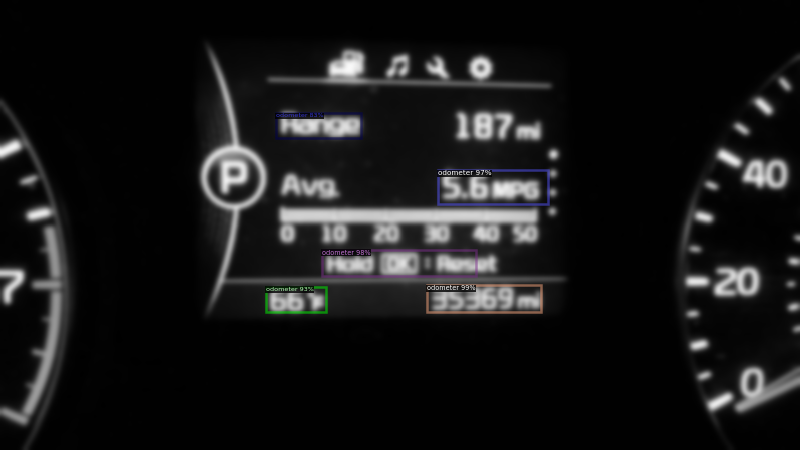

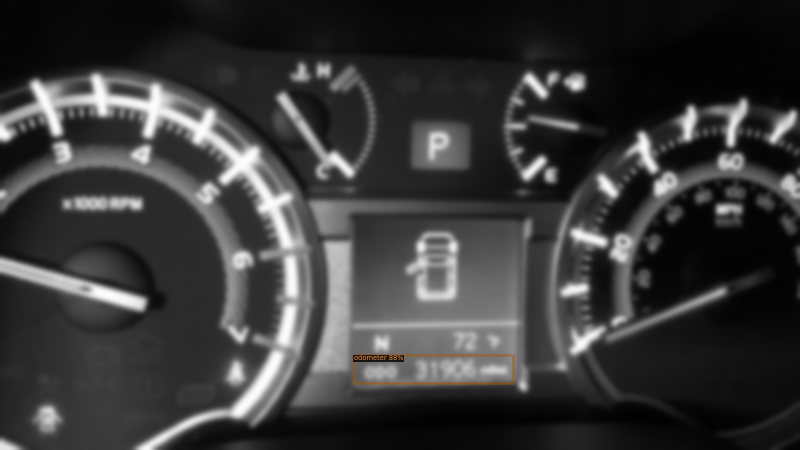

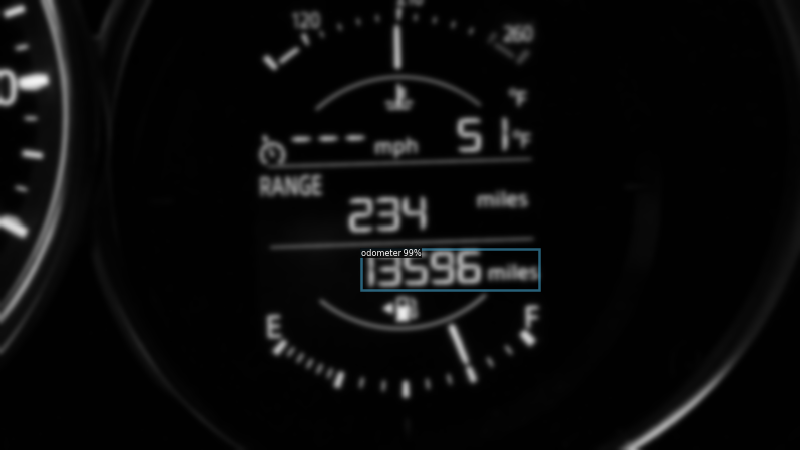

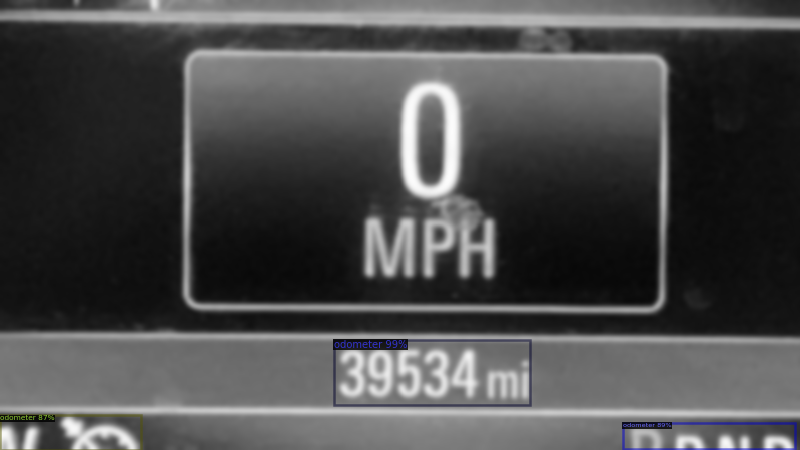

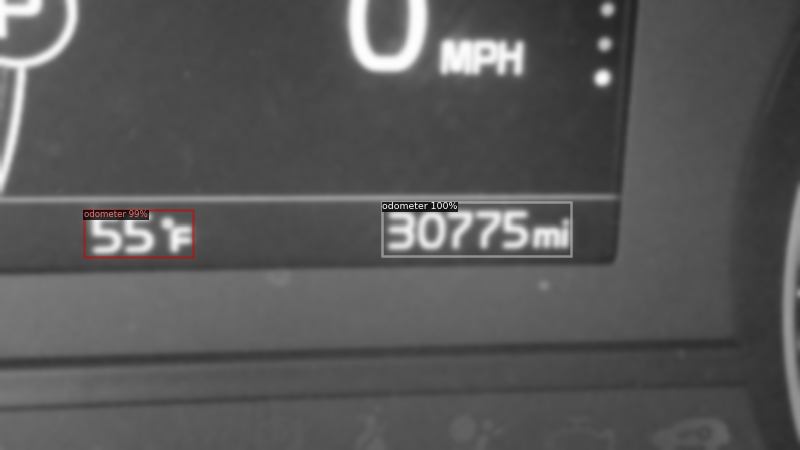

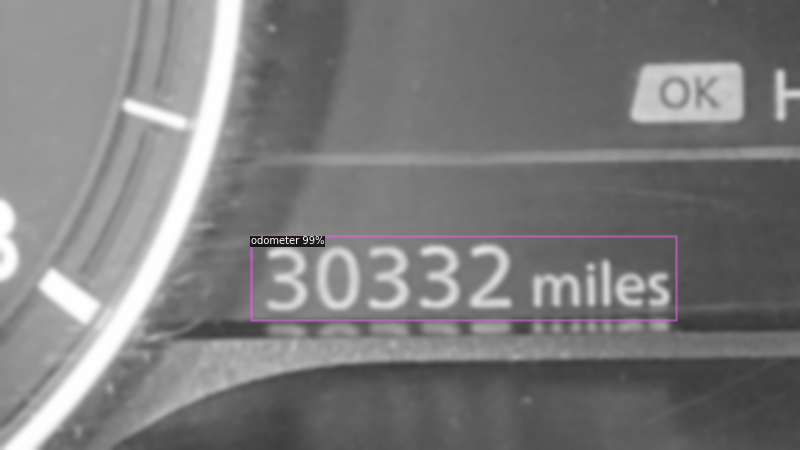

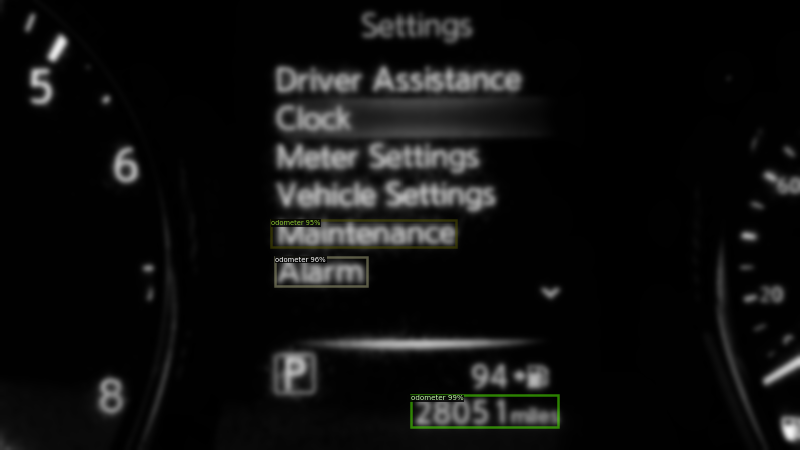

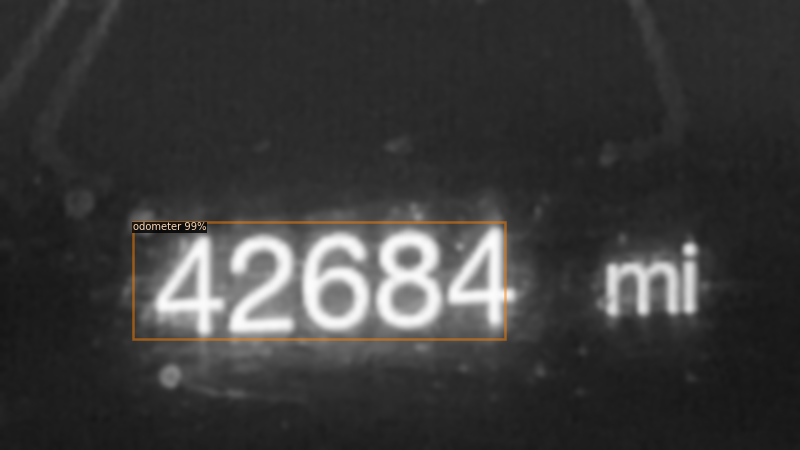

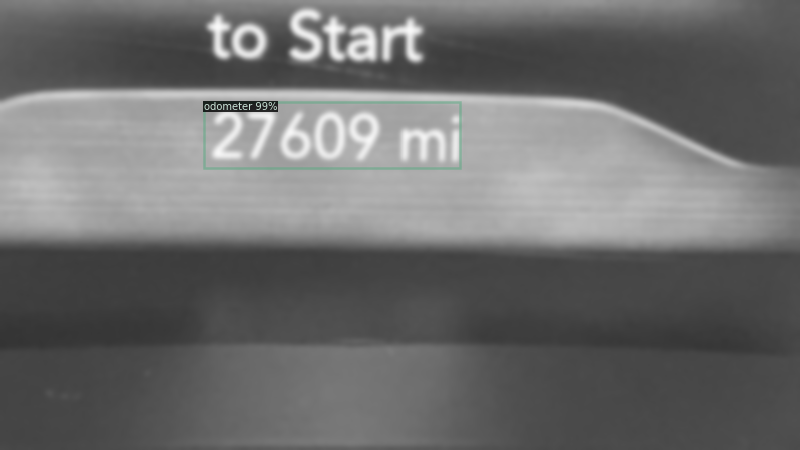

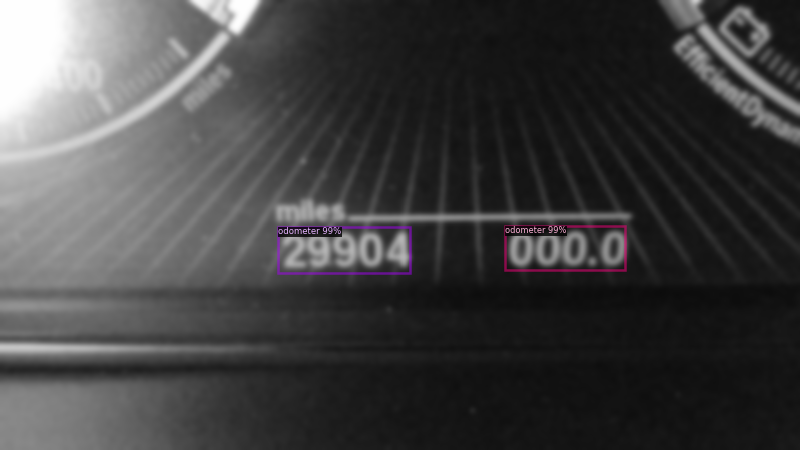

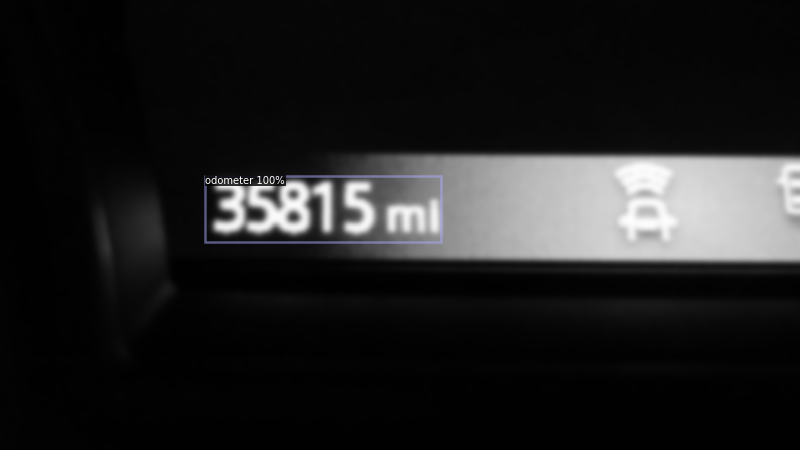

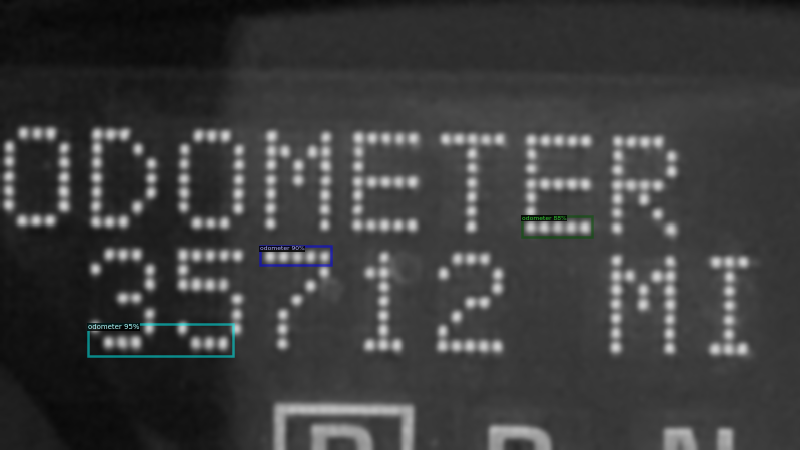

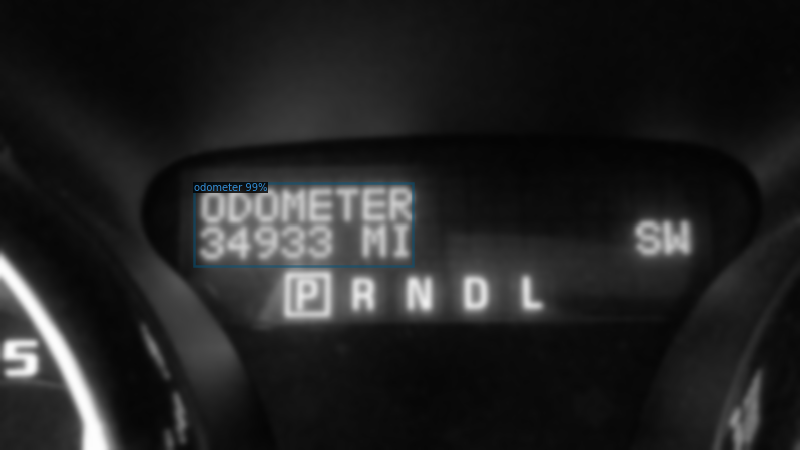

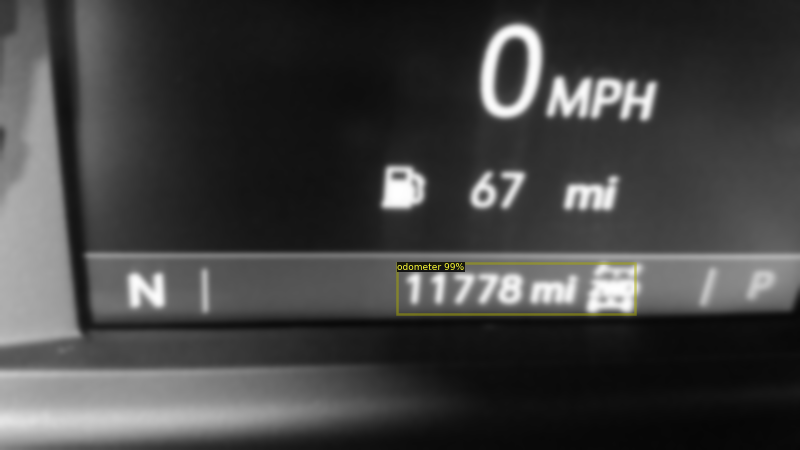

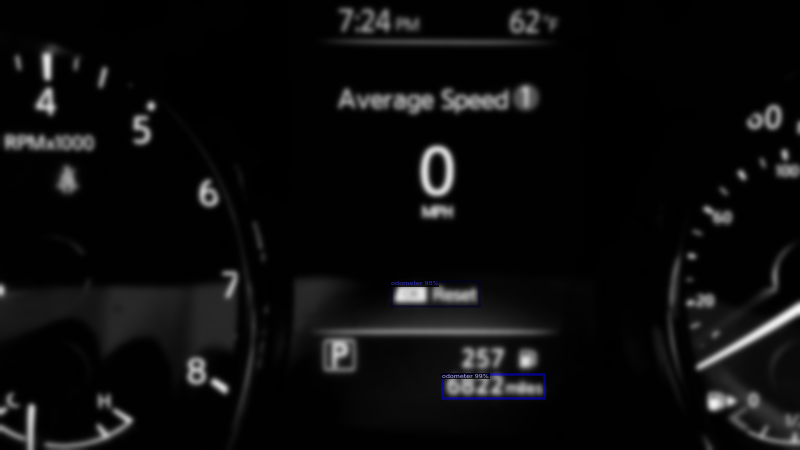

In [ ]:
from detectron2.utils.visualizer import ColorMode
tmp, unfilteredTMP = get_odometer_dicts_for_testing()
for d in tmp:    
    im = cv.imread(d["file_name"])
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    v = Visualizer(im[:, :, ::-1],
                   metadata=odometer_metadata, 
                   scale=0.5, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(out.get_image()[:, :, ::-1])

In [ ]:
# Non-Filtered Data: 6/23 images do not show an odometer prediction (Model was not more than 80% confident)
# Filtered Data: All images show an odometer prediction

In [ ]:
outputs

{'instances': Instances(num_instances=2, image_height=900, image_width=1600, fields=[pred_boxes: Boxes(tensor([[ 884.3475,  747.2295, 1087.2374,  795.9225],
         [ 781.1176,  562.2011,  958.8615,  611.8525]], device='cuda:0')), scores: tensor([0.9911, 0.9829], device='cuda:0'), pred_classes: tensor([0, 0], device='cuda:0')])}

In [ ]:
for d in tmp:
  im = cv.imread(d["file_name"])
  print(predictor(im)['instances'])

Instances(num_instances=3, image_height=900, image_width=1600, fields=[pred_boxes: Boxes(tensor([[ 706.0353,  602.7261,  892.0015,  651.1076],
        [ 551.2046,  509.2307,  813.9545,  559.1644],
        [ 955.5955,  667.6862, 1136.5807,  715.4489]], device='cuda:0')), scores: tensor([0.9948, 0.9747, 0.9649], device='cuda:0'), pred_classes: tensor([0, 0, 0], device='cuda:0')])
Instances(num_instances=3, image_height=900, image_width=1600, fields=[pred_boxes: Boxes(tensor([[ 851.0803,  430.0641, 1264.9619,  554.9489],
        [ 327.4022,  415.4510,  736.8090,  570.8148],
        [ 608.6729,   59.7193, 1064.4663,  223.1252]], device='cuda:0')), scores: tensor([0.9945, 0.9480, 0.9020], device='cuda:0'), pred_classes: tensor([0, 0, 0], device='cuda:0')])
Instances(num_instances=1, image_height=900, image_width=1600, fields=[pred_boxes: Boxes(tensor([[   0.0000,  482.6339, 1460.2697,  737.1229]], device='cuda:0')), scores: tensor([0.9933], device='cuda:0'), pred_classes: tensor([0], device

/content/drive/My Drive/Group Ka-chow's Project/ed_test/90.png


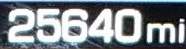

Reading: 25640 mi



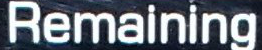

Reading: Remaining



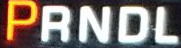

Reading: PRNDL

/content/drive/My Drive/Group Ka-chow's Project/ed_test/91.png


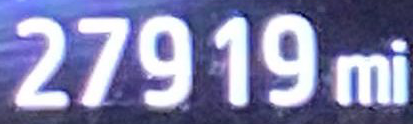

Reading: 27919 mi



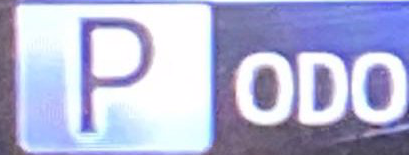

Reading: Wed ovo



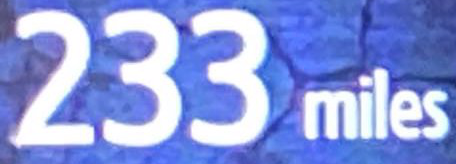

Reading: 233 mies

/content/drive/My Drive/Group Ka-chow's Project/ed_test/92.png


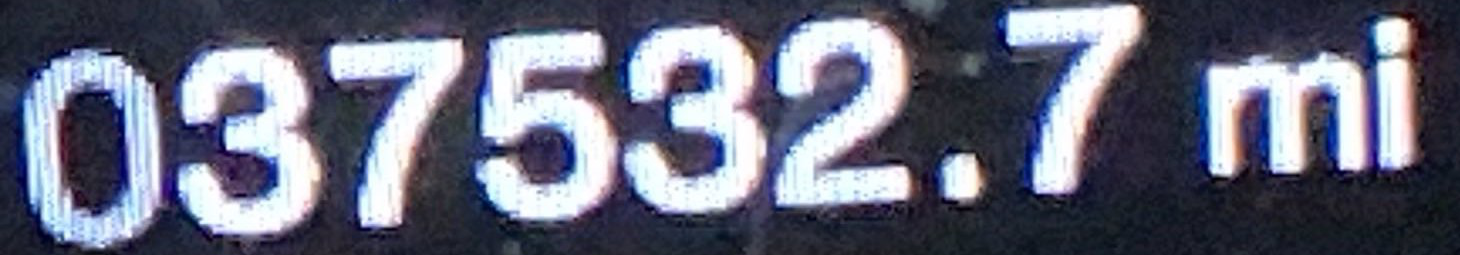

Reading: 037532.7 mi

/content/drive/My Drive/Group Ka-chow's Project/ed_test/93.png


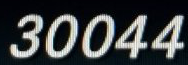

Reading: 30044



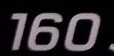

Reading: 60:

/content/drive/My Drive/Group Ka-chow's Project/ed_test/94.png


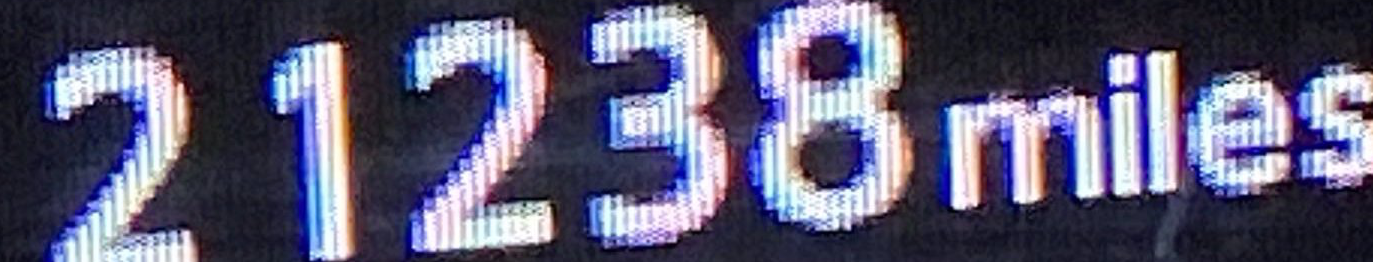

Reading: 
/content/drive/My Drive/Group Ka-chow's Project/ed_test/95.png


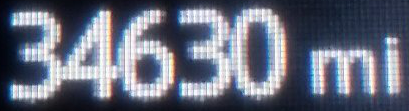

Reading: 34630 mi

/content/drive/My Drive/Group Ka-chow's Project/ed_test/96.png


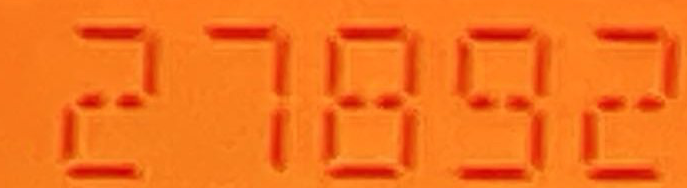

Reading: aaa



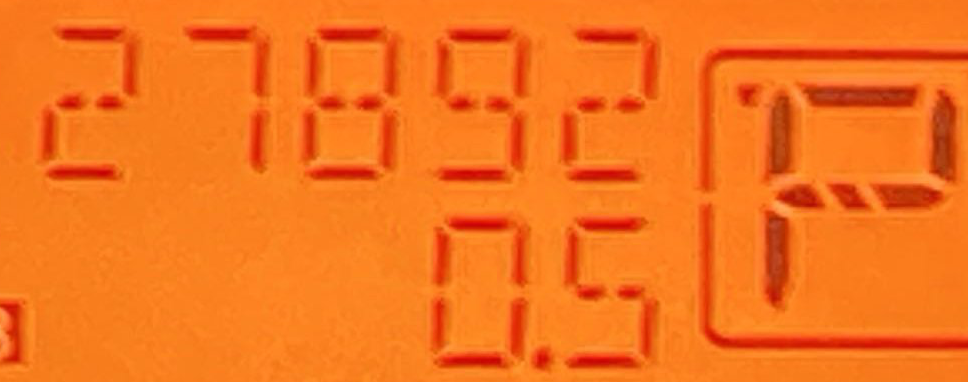

Reading: 
/content/drive/My Drive/Group Ka-chow's Project/ed_test/97.png


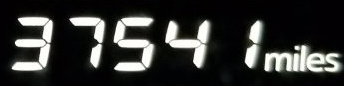

Reading: 


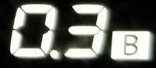

Reading: Qle

/content/drive/My Drive/Group Ka-chow's Project/ed_test/98.png


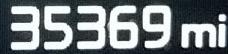

Reading: 353695 mi



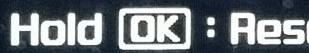

Reading: Hold : Aes



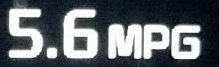

Reading: S.6mpc



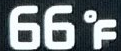

Reading: 66¢



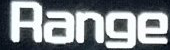

Reading: Range

/content/drive/My Drive/Group Ka-chow's Project/ed_test/99.png


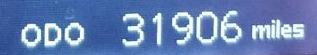

Reading: opo «31906 mies

/content/drive/My Drive/Group Ka-chow's Project/ed_test/100.png


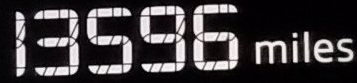

Reading: 35 SB mites

/content/drive/My Drive/Group Ka-chow's Project/ed_test/101.png


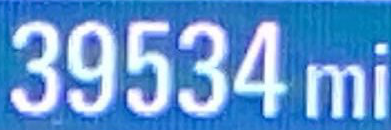

Reading: 39534 mi



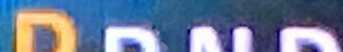

Reading: ri mare em



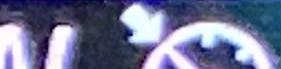

Reading: ag tem,

/content/drive/My Drive/Group Ka-chow's Project/ed_test/102.png


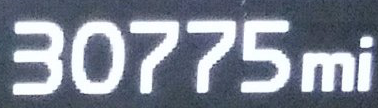

Reading: 307 75 mi



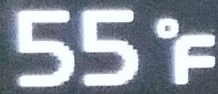

Reading: SS

/content/drive/My Drive/Group Ka-chow's Project/ed_test/103.png


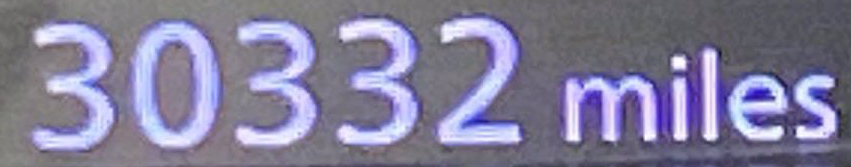

Reading: 30332 miles

/content/drive/My Drive/Group Ka-chow's Project/ed_test/104.png


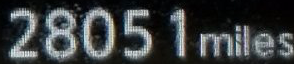

Reading: 2805 1 mites



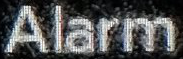

Reading: Alarm



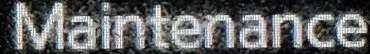

Reading: Maintenance

/content/drive/My Drive/Group Ka-chow's Project/ed_test/105.png


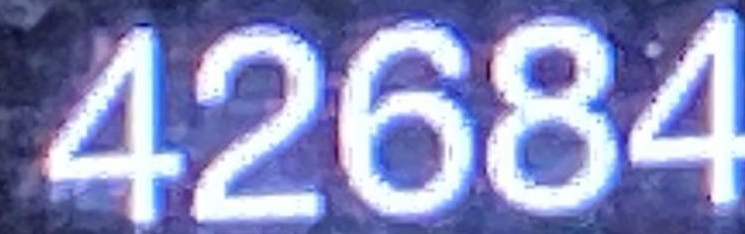

Reading: 42684

/content/drive/My Drive/Group Ka-chow's Project/ed_test/106.png


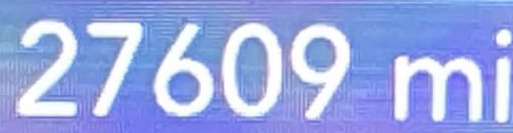

Reading: 27609 mi

/content/drive/My Drive/Group Ka-chow's Project/ed_test/107.png


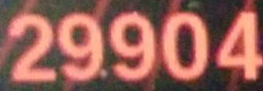

Reading: 29904



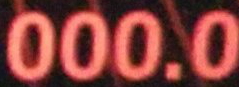

Reading: 000.0

/content/drive/My Drive/Group Ka-chow's Project/ed_test/108.png


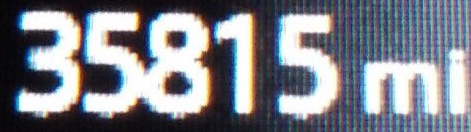

Reading: 35815 mi

/content/drive/My Drive/Group Ka-chow's Project/ed_test/109.png


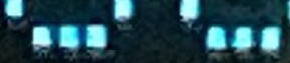

Reading: 


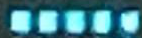

Reading: 


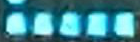

Reading: esena

/content/drive/My Drive/Group Ka-chow's Project/ed_test/110.png


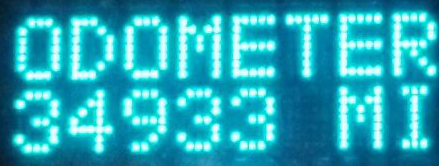

Reading: 
/content/drive/My Drive/Group Ka-chow's Project/ed_test/111.png


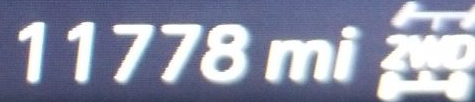

Reading: 11778 mi

/content/drive/My Drive/Group Ka-chow's Project/ed_test/112.png


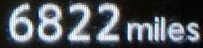

Reading: 6822 miles



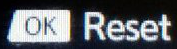

Reading: 


In [ ]:
for d, e in zip(unfilteredTMP, tmp):
  im = cv.imread(d["file_name"])
  im2 = cv.imread(e["file_name"])
  print(d["file_name"])
  for i in range(predictor(im2)['instances'].pred_boxes.tensor.shape[0]):
      miny = int(predictor(im2)['instances'].pred_boxes.tensor[i][0].item()) 
      minx = int(predictor(im2)['instances'].pred_boxes.tensor[i][1].item()) 
      maxy = int(predictor(im2)['instances'].pred_boxes.tensor[i][2].item()) 
      maxx = int(predictor(im2)['instances'].pred_boxes.tensor[i][3].item()) 

      crop = im[minx:maxx, miny:maxy]

      cv2_imshow(crop)

      tests = Image.fromarray(np.uint8(crop*255)).convert('RGB')
      text = tess.image_to_string(tests, lang='eng', config='--psm 7 --oem 3 outputbase digits')

      print("Reading: {0}".format(text))